# Object Detection Demo: City Network of Capture Points
Welcome to the object detection inference walkthrough!  This notebook will walk you step by step through the process of using a pre-trained model to detect objects in an image. Make sure to follow the [installation instructions](https://github.com/tensorflow/models/blob/master/object_detection/g3doc/installation.md) before you start.

# Imports

In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import getpass
import shutil

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

from PIL import ImageGrab
import time
import pandas as pd

import cv2

import requests
from io import BytesIO

from copy import deepcopy

import scipy.misc

from datetime import datetime

import arcgis

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Env setup

In [2]:
# This is needed to display the images.
%matplotlib inline

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")

# Establish Connection to ArcGIS Online via ArcGIS API for Python

#### Authenticate

In [4]:
portals_dict = {
    "esrifederal_gis": r"https://esrifederal.maps.arcgis.com",
    "natgov_gis": r"http://esri-natgov105.eastus.cloudapp.azure.com/arcgis",
    "dot_gis": r"http://dot.esri.com/portal",
    "dev_gis": r"http://govdev.eastus.cloudapp.azure.com/arcgis",
    "local_gis": r"https://anieto.esri.com/arcgis",
    "brett_gis": r"https://agsbase.dcwebgis.net/portal",
    "bill_gis": r"https://idt.esri.com/portal"
}

gis_url = portals_dict["esrifederal_gis"]

if gis_url == portals_dict["esrifederal_gis"]:
    gis_app_id = r"wt3QUR1M4eum0TVI"
    print("Attempting to log in to '{0}'...".format(gis_url))
    gis = arcgis.gis.GIS(gis_url, client_id=gis_app_id)
    print("Successfully logged in as: " + gis.properties.user.username)
else:
    gis_username = getpass.getpass(prompt="Username: ")
    gis_pw = getpass.getpass(prompt="Password: ")
    print("Attempting to log in to '{0}'...".format(gis_url))
    gis = arcgis.gis.GIS(gis_url, gis_username, gis_pw, verify_cert=False)
    print("Successfully logged in as: " + gis.properties.user.username)

Attempting to log in to 'https://esrifederal.maps.arcgis.com'...
Please sign in to your GIS and paste the code that is obtained below.
If a web browser does not automatically open, please navigate to the URL below yourself instead.
Opening web browser to navigate to: https://esrifederal.maps.arcgis.com/sharing/rest/oauth2/authorize?client_id=wt3QUR1M4eum0TVI&response_type=code&expiration=-1&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob
Enter code obtained on signing in using SAML: ········
Successfully logged in as: albe9057@esri.com_esrifederal


## Object detection imports
Here are the imports from the object detection module.

In [5]:
from utils import label_map_util

from utils import visualization_utils as vis_util

# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_CKPT` to point to a new .pb file.  

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

### Model: SSD Mobilenet on COCO

In [6]:
# What model to download.
MODEL_NAME = 'ssd_mobilenet_v1_coco_11_06_2017'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('data', 'mscoco_label_map.pbtxt')

NUM_CLASSES = 90

In [7]:
# What model to download.
MODEL_NAME = 'ssd_inception_v2_coco_2017_11_17'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('data', 'mscoco_label_map.pbtxt')

NUM_CLASSES = 90

## Load a (frozen) Tensorflow model into memory.

In [8]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [9]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [10]:
categories

[{'id': 1, 'name': 'person'},
 {'id': 2, 'name': 'bicycle'},
 {'id': 3, 'name': 'car'},
 {'id': 4, 'name': 'motorcycle'},
 {'id': 6, 'name': 'bus'},
 {'id': 7, 'name': 'train'},
 {'id': 8, 'name': 'truck'}]

## Helper code

In [11]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

This is a helper function that takes the detection graph output tensor (np arrays), stacks the classes and scores, and determines if the class for a person (1) is available within a certain score and within a certain amount of objects

In [12]:
def object_counter(classes_arr, scores_arr, score_thresh=0.2):
    # Process the numpy array of classes from the model
    stacked_arr = np.stack((classes_arr, scores_arr), axis=-1)
    # Convert to pandas dataframe for easier querying
    detection_df = pd.DataFrame(stacked_arr)
    # Retrieve total count of cars with score threshold above param value
    detected_cars = detection_df[(detection_df[0] == 3.0) & (detection_df[1] > score_thresh)]
    detected_people =  detection_df[(detection_df[0] == 1.0) & (detection_df[1] > score_thresh)]
    detected_bicycles =  detection_df[(detection_df[0] == 2.0) & (detection_df[1] > score_thresh)]
    detected_motorcycles =  detection_df[(detection_df[0] == 4.0) & (detection_df[1] > score_thresh)]
    detected_buses =  detection_df[(detection_df[0] == 6.0) & (detection_df[1] > score_thresh)]
    detected_trucks =  detection_df[(detection_df[0] == 8.0) & (detection_df[1] > score_thresh)]
    
    car_count = len(detected_cars)
    people_count = len(detected_people)
    bicycle_count = len(detected_bicycles)
    motorcycle_count = len(detected_motorcycles)
    bus_count = len(detected_buses)
    truck_count = len(detected_trucks)

    return car_count, people_count, bicycle_count, motorcycle_count, bus_count, truck_count

def return_lat(row):
    return row['location']['latitude']

def return_lon(row):
    return row['location']['longitude']

# Multiple Camera Iteration Prototyping

## P1: Use existing feature service and send model outputs as updates

<Item title:"CobbCountyCameras_v01" type:Feature Layer Collection owner:albe9057@esri.com_esrifederal>
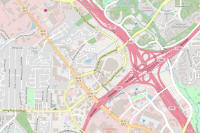

In [13]:
object_point_srvc = gis.content.search("CobbCountyCameras_v01", item_type="feature service")[0]
object_point_srvc

In [14]:
# Convert our existing service into a pandas dataframe
object_point_lyr = object_point_srvc.layers[0]
obj_fset = object_point_lyr.query()  #querying without any conditions returns all the features
obj_df = obj_fset.df
all_features = obj_fset.features
original_feature = all_features[1]
feature_to_be_updated = deepcopy(original_feature)

In [15]:
obj_df

,CreationDate,Creator,EditDate,Editor,GlobalID,OBJECTID,activity_timestamp,attribute_0,content,createdAt,...,threshold_val_buses,threshold_val_cars,threshold_val_ped,threshold_val_trck,thrsh_status_bus,thrsh_status_cars,thrsh_status_ped,thrsh_status_trck,updatedAt,SHAPE
0,None,None,None,None,6e3947ed-7c39-46f2-8c54-80c8e885ef12,112,None,None,https://www.cobbcommute.org/CameraProxy/Index?...,None,...,200,200,200,200,Below,Below,Below,Below,None,"{'x': -9402733.462, 'y': 4014445.4543000013}"
1,None,None,None,None,e5aa01ee-bf36-4a94-a652-8155e478481a,113,None,None,https://www.cobbcommute.org/CameraProxy/Index?...,None,...,200,200,200,200,Below,Below,Below,Below,None,"{'x': -9402693.929, 'y': 4014468.0446000025}"
2,None,None,None,None,44dfaa2f-31db-440a-9639-6183e6d63c7f,114,None,None,https://www.cobbcommute.org/CameraProxy/Index?...,None,...,200,200,200,200,Below,Below,Below,Below,None,"{'x': -9402435.5526, 'y': 4014701.0068999976}"
3,None,None,None,None,d8f03842-91e6-4e8b-884f-3aad9480e5b6,115,None,None,https://www.cobbcommute.org/CameraProxy/Index?...,None,...,200,200,200,200,Below,Below,Below,Below,None,"{'x': -9403301.0543, 'y': 4013961.6180000007}"
4,None,None,None,None,209c0322-3ad0-42a7-a80d-6b15d9a73012,116,None,None,https://www.cobbcommute.org/CameraProxy/Index?...,None,...,200,200,200,200,Below,Below,Below,Below,None,"{'x': -9403327.1719, 'y': 4013976.783}"
5,None,None,None,None,caac3512-ecac-46ad-9c1a-c213f0711a36,117,None,None,https://www.cobbcommute.org/CameraProxy/Index?...,None,...,200,200,200,200,Below,Below,Below,Below,None,"{'x': -9403134.5081, 'y': 4013664.1466000006}"
6,None,None,None,None,a917d63d-d3f3-4705-a65e-5f90adeeb0aa,118,None,None,https://www.cobbcommute.org/CameraProxy/Index?...,None,...,200,200,200,200,Below,Below,Below,Below,None,"{'x': -9403081.127, 'y': 4013706.7436000034}"
7,None,None,None,None,92d90037-6e61-415d-9e6e-600fe08b5ad8,120,None,None,https://www.cobbcommute.org/CameraProxy/Index?...,None,...,200,200,200,200,Below,Below,Below,Below,None,"{'x': -9403213.4338, 'y': 4013273.2920999974}"
8,None,None,None,None,471b9152-9cda-4b42-a280-06a0df6a2109,121,None,None,https://www.cobbcommute.org/CameraProxy/Index?...,None,...,200,200,200,200,Below,Below,Below,Below,None,"{'x': -9402963.2101, 'y': 4013196.6242000014}"
9,None,None,None,None,f91bd4b3-9fc6-4f31-a1a9-c562124782c1,122,None,None,https://www.cobbcommute.org/CameraProxy/Index?...,None,...,200,200,200,200,Below,Below,Below,Below,None,"{'x': -9403450.5928, 'y': 4013687.2523000017}"


In [19]:
# Establish runtime parameters

overwrite_attachment = True
upload_source = False
write_trends = True
reset_trends = True

# Start up TF detection graph
with detection_graph.as_default():
    
    # Start up TF session using the detection graph
    with tf.Session(graph=detection_graph) as sess:
        
        # Refer to specific input/output tensors
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')

        # Start iteration that determines how many detection sweeps occur
        for iteration in range(10):
            
            # Retrieve the list of cameras from the feature service (as a dataframe)
            ddot_df = obj_df
            
            for ix in range(0,len(obj_df)):
                print("Processing camera {0} of {1}...".format(str(ix+1), str(len(obj_df))))

                # Retrieve camera information
                camera_jpeg_url = obj_df.iloc[ix]['content']
#                 camera_name = ddot_df.iloc[ix]['name']
#                 camera_id = ddot_df.iloc[ix]['publicId']
                
                # Retrieve the camera image
                camera_response = requests.get(camera_jpeg_url)
                
#                 # Perform attachment of source image
                if upload_source:
                    streamed_response = requests.get(camera_jpeg_url, stream=True)
                    with open('source.jpg', 'wb') as out_file:
                        shutil.copyfileobj(streamed_response.raw, out_file)
    #                 del response                

                image = Image.open(BytesIO(camera_response.content))
                image_np = load_image_into_numpy_array(image)
                image_np_expanded = np.expand_dims(image_np, axis=0)

                (boxes, scores, classes, num) = sess.run(
                      [detection_boxes, detection_scores, detection_classes, num_detections],
                      feed_dict={image_tensor: image_np_expanded})

                vis_util.visualize_boxes_and_labels_on_image_array(
                      image_np,
                      np.squeeze(boxes),
                      np.squeeze(classes).astype(np.int32),
                      np.squeeze(scores),
                      category_index,
                      use_normalized_coordinates=True,
                      line_thickness=8,
                      max_boxes_to_draw=None,
                      min_score_thresh=0.30
                )
                
                car_count, people_count, bicycle_count, motorcycle_count, bus_count, truck_count = object_counter(np.squeeze(classes).astype(np.int32), np.squeeze(scores))
                vehicle_count = car_count + motorcycle_count + bus_count + truck_count
                total_count = vehicle_count + bicycle_count + people_count
                
                # Retrieve the feature from the feature layer to update
                obj_fset = object_point_lyr.query(where="""content = '"""+camera_jpeg_url+"""'""", return_geometry=False)  
                all_features = obj_fset.features
                original_feature = all_features[0]
                feature_to_be_updated = deepcopy(original_feature)
                
                features_for_update = []
                feature_to_be_updated.attributes['rt_object_count'] = total_count
                feature_to_be_updated.attributes['rt_vehicle_count'] = vehicle_count
                feature_to_be_updated.attributes['rt_car_count'] = car_count
                feature_to_be_updated.attributes['rt_bus_count'] = bus_count
                feature_to_be_updated.attributes['rt_truck_count'] = truck_count
                feature_to_be_updated.attributes['rt_motorcycle_count'] = motorcycle_count
                feature_to_be_updated.attributes['rt_pedestrian_count'] = people_count
                feature_to_be_updated.attributes['rt_bicycle_count'] = bicycle_count
                
                feature_to_be_updated.attributes['source_image'] = camera_jpeg_url
                
                # Perform Trend Process
                if write_trends:
                    
                    # If the trend needs to be reset
                    if reset_trends and iteration==0:
                        print("Resetting trends...")
                        feature_to_be_updated.attributes['histval_10am_th_car'] = car_count
                        feature_to_be_updated.attributes['histval_10am_th_ped'] = people_count
                        feature_to_be_updated.attributes['histval_10am_th_bus'] = bus_count
                        feature_to_be_updated.attributes['histval_10am_th_trck'] = truck_count
                        
                        histval_car = car_count
                        histval_ped = people_count
                        histval_bus = bus_count
                        histval_truck = truck_count

                    # If the trend does not need to be reset
                    else:
                        histval_car = feature_to_be_updated.attributes['histval_10am_th_car']
                        histval_ped = feature_to_be_updated.attributes['histval_10am_th_ped']
                        histval_bus = feature_to_be_updated.attributes['histval_10am_th_bus']
                        histval_truck = feature_to_be_updated.attributes['histval_10am_th_trck']
                        
                        if histval_car == None:
                            histval_car = car_count
                        if histval_bus == None:
                            histval_bus = bus_count
                        if histval_truck == None:
                            histval_truck = truck_count
                        if histval_ped == None:
                            histval_ped = people_count                            
                    
                        # Calculate the new trend value and store it for the new update
                        feature_to_be_updated.attributes['histval_10am_th_car'] = (car_count + histval_car) / 2
                        feature_to_be_updated.attributes['histval_10am_th_ped'] = (people_count + histval_ped) / 2
                        feature_to_be_updated.attributes['histval_10am_th_bus'] = (bus_count + histval_bus) / 2
                        feature_to_be_updated.attributes['histval_10am_th_trck'] = (truck_count + histval_truck) / 2
                        
                    # Determine threshold percent, value, and status
                    thrshpcnt_car = feature_to_be_updated.attributes['threshold_val_cars']
                    thrshpcnt_ped = feature_to_be_updated.attributes['threshold_val_ped']
                    thrshpcnt_bus = feature_to_be_updated.attributes['threshold_val_buses']
                    thrshpcnt_truck = feature_to_be_updated.attributes['threshold_val_trck']
                    
                    # Perform writes to the threshold status field
                    
                    if car_count > (histval_car * thrshpcnt_car):
                        feature_to_be_updated.attributes['thrsh_status_cars'] = "Above"           
                    else:
                        feature_to_be_updated.attributes['thrsh_status_cars'] = "Below"
                        
                    if people_count > (histval_ped * thrshpcnt_ped):
                        feature_to_be_updated.attributes['thrsh_status_ped'] = "Above"
                    else:
                        feature_to_be_updated.attributes['thrsh_status_ped'] = "Below"                        
                        
                    if bus_count > (histval_bus * thrshpcnt_bus):
                        feature_to_be_updated.attributes['thrsh_status_bus'] = "Above"
                    else:
                        feature_to_be_updated.attributes['thrsh_status_bus'] = "Below"                        
                        
                    if truck_count > (histval_truck * thrshpcnt_truck):
                        feature_to_be_updated.attributes['thrsh_status_trck'] = "Above"
                    else:
                        feature_to_be_updated.attributes['thrsh_status_trck'] = "Below"                        
                                               
                # Store attribute updates and send edit request
                features_for_update.append(feature_to_be_updated)
                object_point_lyr.edit_features(updates=features_for_update)    
        
                # Perform attachment of detected image
                scipy.misc.imsave('detected_objs.jpg', image_np)
#                 obj_id = feature_to_be_updated.attributes['F__OBJECTID']
                obj_id = feature_to_be_updated.attributes['OBJECTID']
                
                if overwrite_attachment:
                    for attachment in object_point_lyr.attachments.get_list(obj_id):
                        object_point_lyr.attachments.delete(obj_id, attachment['id'])
                                               
                object_point_lyr.attachments.add(obj_id, 'detected_objs.jpg')
                
                if upload_source:
                    object_point_lyr.attachments.add(obj_id, 'source.jpg')
                                    

Processing camera 1 of 14...
Resetting trends...
Processing camera 2 of 14...
Resetting trends...
Processing camera 3 of 14...
Resetting trends...
Processing camera 4 of 14...
Resetting trends...
Processing camera 5 of 14...
Resetting trends...
Processing camera 6 of 14...
Resetting trends...
Processing camera 7 of 14...
Resetting trends...
Processing camera 8 of 14...
Resetting trends...
Processing camera 9 of 14...
Resetting trends...
Processing camera 10 of 14...
Resetting trends...
Processing camera 11 of 14...
Resetting trends...
Processing camera 12 of 14...
Resetting trends...
Processing camera 13 of 14...
Resetting trends...
Processing camera 14 of 14...
Resetting trends...
Processing camera 1 of 14...


KeyboardInterrupt: 

# TODOs

- Change "Reset Trend Routine"

- Option 1
    - Write function to build image training data for labeling
    - Retrieve training data for "crowd blobs"
    - Label images
    - Export to PASCAL VOC
    - Train model in TF
    
- Option 2
    - Get KITTI model working on static images
    - Determine performance
    * - This model is not good for people 

# TODO

o	Write python script to generate unlabeled images from Cobb County feed – In progress

o	Schedule script to execute on:

    	Event (daytime) - Pending

    	Non-event (daytime) - Pending

    	Event (night-time) – Pending  (Optional)

    	Non-event (night-time) – Pending  (Optional)

o	Training Data Labeling – Pending

o	Model Training – Pending

o	Model Testing – Pending

o	Front-end Config - Pending

#### Reset Routine

https://esrifederal.maps.arcgis.com/home/webmap/viewer.html?webmap=255196da558749209dc63c07ffb38ae6

In [48]:
for iteration in range(1):
    
    features_for_update = []
            
    for ix in range(0,len(obj_df)):
        print("Resetting values for camera {0} of {1}...".format(str(ix), len(obj_df)))

        # Retrieve camera information
        camera_name = ddot_df.iloc[ix]['name']

        # Retrieve the feature from the feature layer to update
        obj_fset = object_point_lyr.query(where="""name = '"""+camera_name+"""'""", return_geometry=False)  
        all_features = obj_fset.features
        original_feature = all_features[0]
        feature_to_be_updated = deepcopy(original_feature)

        
        feature_to_be_updated.attributes['rt_object_count'] = 0
        feature_to_be_updated.attributes['rt_vehicle_count'] = 0
        feature_to_be_updated.attributes['rt_car_count'] = 0
        feature_to_be_updated.attributes['rt_bus_count'] = 0
        feature_to_be_updated.attributes['rt_truck_count'] = 0
        feature_to_be_updated.attributes['rt_motorcycle_count'] = 0
        feature_to_be_updated.attributes['rt_pedestrian_count'] = 0
        feature_to_be_updated.attributes['rt_bicycle_count'] = 0
        
        feature_to_be_updated.attributes['histval_10am_th_car'] = None
        feature_to_be_updated.attributes['histval_10am_th_ped'] = None
        feature_to_be_updated.attributes['histval_10am_th_bus'] = None
        feature_to_be_updated.attributes['histval_10am_th_trck'] = None
        
        feature_to_be_updated.attributes['thrsh_status_cars'] = "Not Tracked"
        feature_to_be_updated.attributes['thrsh_status_ped'] = "Not Tracked" 
        feature_to_be_updated.attributes['thrsh_status_bus'] = "Not Tracked" 
        feature_to_be_updated.attributes['thrsh_status_trck'] = "Not Tracked"           

        features_for_update.append(feature_to_be_updated)
        
    object_point_lyr.edit_features(updates=features_for_update)

Restting values for camera 0 of 100...
Restting values for camera 1 of 100...
Restting values for camera 2 of 100...
Restting values for camera 3 of 100...
Restting values for camera 4 of 100...
Restting values for camera 5 of 100...
Restting values for camera 6 of 100...
Restting values for camera 7 of 100...
Restting values for camera 8 of 100...
Restting values for camera 9 of 100...
Restting values for camera 10 of 100...
Restting values for camera 11 of 100...
Restting values for camera 12 of 100...
Restting values for camera 13 of 100...
Restting values for camera 14 of 100...
Restting values for camera 15 of 100...
Restting values for camera 16 of 100...
Restting values for camera 17 of 100...
Restting values for camera 18 of 100...
Restting values for camera 19 of 100...
Restting values for camera 20 of 100...
Restting values for camera 21 of 100...
Restting values for camera 22 of 100...
Restting values for camera 23 of 100...
Restting values for camera 24 of 100...
Restting v

Set trend threshold percentages

In [57]:
thresh_percent = 2.0

reset_trends = True

for iteration in range(1):
    
    features_for_update = []
            
    for ix in range(0,111):
        print("Setting trend threshold values for camera {0} of 111...".format(str(ix)))

        # Retrieve camera information
        camera_name = ddot_df.iloc[ix]['name']

        # Retrieve the feature from the feature layer to update
        obj_fset = object_point_lyr.query(where="""name = '"""+camera_name+"""'""", return_geometry=False)  
        all_features = obj_fset.features
        original_feature = all_features[0]
        feature_to_be_updated = deepcopy(original_feature)
        
        feature_to_be_updated.attributes['threshold_val_cars'] = thresh_percent
        feature_to_be_updated.attributes['threshold_val_ped'] = thresh_percent
        feature_to_be_updated.attributes['threshold_val_buses'] = thresh_percent
        feature_to_be_updated.attributes['threshold_val_trck'] = thresh_percent    
        
        feature_to_be_updated.attributes['thrsh_status_cars'] = "Not Tracked"
        feature_to_be_updated.attributes['thrsh_status_ped'] = "Not Tracked" 
        feature_to_be_updated.attributes['thrsh_status_bus'] = "Not Tracked" 
        feature_to_be_updated.attributes['thrsh_status_trck'] = "Not Tracked" 
        
        if reset_trends:
            feature_to_be_updated.attributes['histval_10am_th_car'] = None
            feature_to_be_updated.attributes['histval_10am_th_ped'] = None
            feature_to_be_updated.attributes['histval_10am_th_bus'] = None
            feature_to_be_updated.attributes['histval_10am_th_trck'] = None


        features_for_update.append(feature_to_be_updated)
        
    object_point_lyr.edit_features(updates=features_for_update)

Setting trend threshold values for camera 0 of 111...
Setting trend threshold values for camera 1 of 111...
Setting trend threshold values for camera 2 of 111...
Setting trend threshold values for camera 3 of 111...
Setting trend threshold values for camera 4 of 111...
Setting trend threshold values for camera 5 of 111...
Setting trend threshold values for camera 6 of 111...
Setting trend threshold values for camera 7 of 111...
Setting trend threshold values for camera 8 of 111...
Setting trend threshold values for camera 9 of 111...
Setting trend threshold values for camera 10 of 111...
Setting trend threshold values for camera 11 of 111...
Setting trend threshold values for camera 12 of 111...
Setting trend threshold values for camera 13 of 111...
Setting trend threshold values for camera 14 of 111...
Setting trend threshold values for camera 15 of 111...
Setting trend threshold values for camera 16 of 111...
Setting trend threshold values for camera 17 of 111...
Setting trend thresh